# Supervised SRBM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import random

# Change accordingly to your directory structure
sys.path.append('../')
import RBM

## MNIST

In [3]:
N = 10
# Initialization scheme.
# Initialize w with Cholesky solution W_phi and mass=5 sigma=1
# init_cond = {'w':torch.DoubleTensor(W_phi.copy()),'m':5., 'sig':1.}
# init_cond = {'m':3., 'sig':1., 'm_scheme':'local'}
# init_cond = {'w_sig':1e-1, 'm':3., 'sig':1., 'm_scheme':'global'}
init_cond = {'w_sig':1e-1, 'm':12., 'sig':1., 'm_scheme':0}

# Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Initialize SRBM
rbm = RBM.SRBM(n_v=784,n_h=N,k=10,init_cond=init_cond)

# For autograd if implimented
# train_op = optim.SGD(rbm.parameters(),1e-7)
# train_op = optim.Adam(rbm.parameters(),1e-5)

# Check initial coupling matrix
print(rbm.w)

# Training parameters
lr = 1e-3

epochs = 10
batch_size = 31

train_ds = datasets.MNIST('../data',
                          train=True,
                          download = True,
                          transform = transforms.Compose(
                              [transforms.ToTensor()])
                         )

# Use only part of data because it is memory intensive
train_ds, validation_data = random_split(train_ds, [3000, 57000])

train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size
)

Initializing model SRBM-230426_155154
Parameter containing:
tensor([[ 0.0300,  0.0242,  0.0283,  ...,  0.0003, -0.1820, -0.0023],
        [ 0.2050, -0.0062,  0.1486,  ..., -0.1608,  0.0211, -0.0627],
        [-0.1256,  0.0034, -0.0459,  ..., -0.1050, -0.0676,  0.0686],
        ...,
        [-0.1288, -0.0236,  0.0666,  ...,  0.1220, -0.1517,  0.0805],
        [-0.0905, -0.0274,  0.0431,  ..., -0.1084,  0.0130,  0.1464],
        [-0.0793,  0.0114,  0.0051,  ..., -0.0576, -0.0209, -0.0884]],
       requires_grad=True)


In [4]:
# Save and load model
rbm.save('../models/')
saved_model = rbm.name
print(saved_model)
rbm = RBM.SRBM(load='../models/'+saved_model+'.npz')

SRBM-230426_155154
Loading model from ../models/SRBM-230426_155154.npz


In [5]:
!rm ../models/*.npz

In [6]:
# Train the model
history = rbm.fit(train_dl, epochs, lr, verbose=True, lr_decay=0)

epoch :0 lr: 0.00100 loss : -6.83993
epoch :1 lr: 0.00100 loss : -4.09127
epoch :2 lr: 0.00100 loss : -4.07286
epoch :3 lr: 0.00100 loss : -4.06566
epoch :4 lr: 0.00100 loss : -4.05008
epoch :5 lr: 0.00100 loss : -4.01519
epoch :6 lr: 0.00100 loss : -3.93947
epoch :7 lr: 0.00100 loss : -3.76754
epoch :8 lr: 0.00100 loss : -3.55490
epoch :9 lr: 0.00100 loss : -3.42703


# Training result

In [7]:
plot_dir = '../plots/'
model_name ='normal'

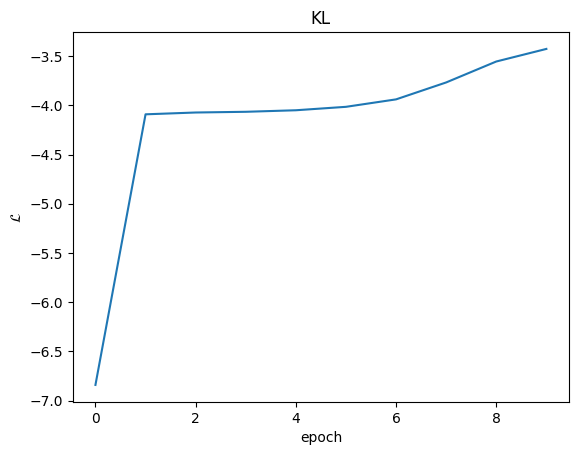

In [8]:
# Loss function
plt.plot(np.arange(len(history['loss'])),history['loss'])
plt.title('KL')
plt.xlabel('epoch')
plt.ylabel(r'$\mathcal{L}$')
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

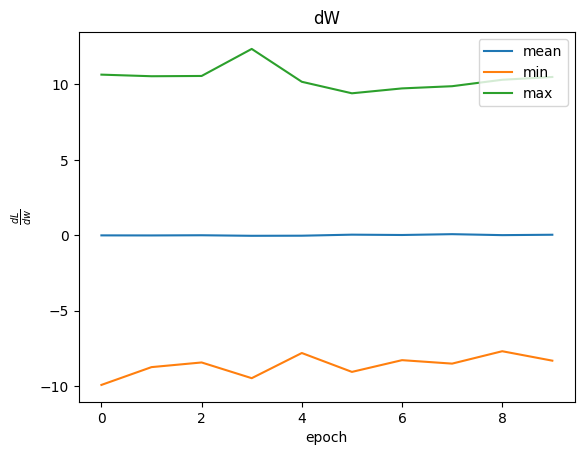

In [9]:
# Gradient
plt.plot(np.arange(len(history['dw'])),np.mean(np.mean(history['dw'], axis=1),axis=1), label='mean')
plt.plot(np.arange(len(history['dw'])),np.min(np.min(history['dw'], axis=1),axis=1), label='min')
plt.plot(np.arange(len(history['dw'])),np.max(np.max(history['dw'], axis=1),axis=1), label='max')
plt.title('dW')
plt.xlabel('epoch')
plt.ylabel(r'$\frac{d L}{dw}$')
plt.legend()
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

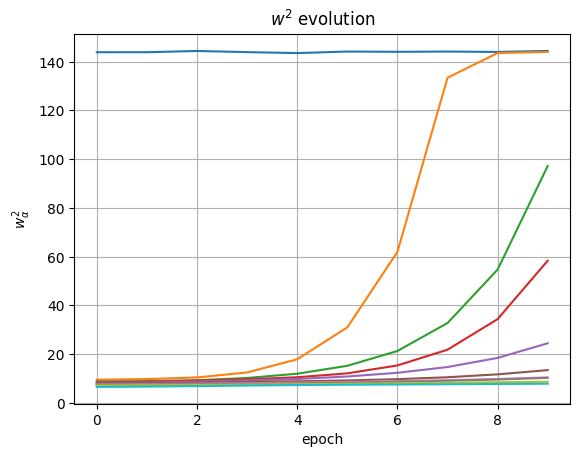

In [10]:
# SVD of coupling matrix squared
s_hist = np.zeros((epochs,N))
for i in range(epochs):
    _, s_, _ = np.linalg.svd(history['w'][i])
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist**2)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

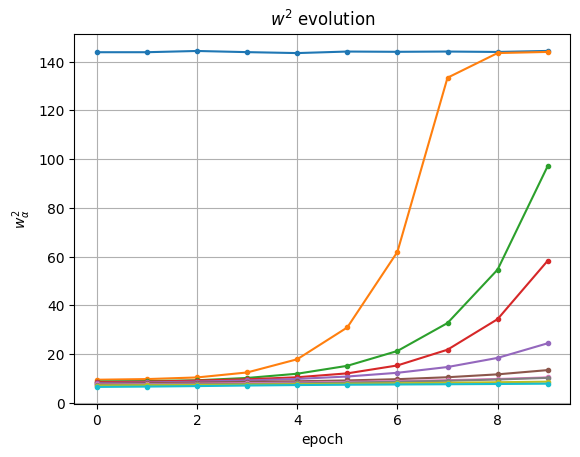

In [11]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:]**2, '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

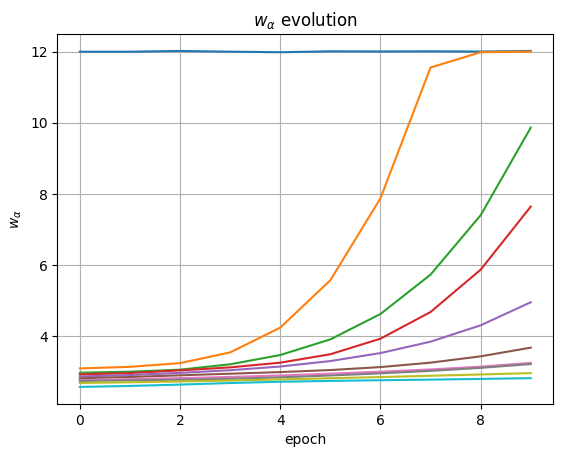

In [12]:
# SVD of coupling matrix not squared
plt.plot(np.arange(epochs),s_hist, '-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

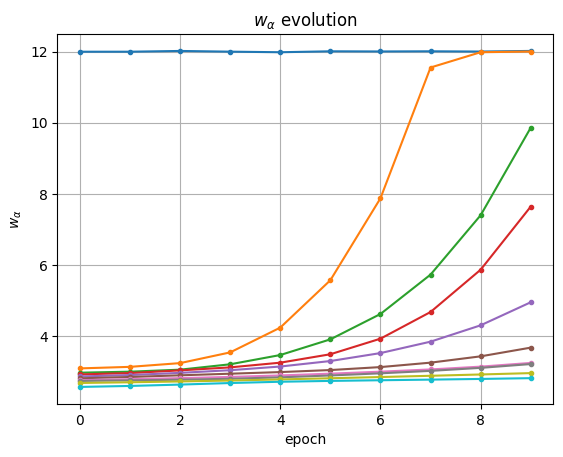

In [13]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

/tmp/ipykernel_5772/3247434065.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  s_hist[i] = s_


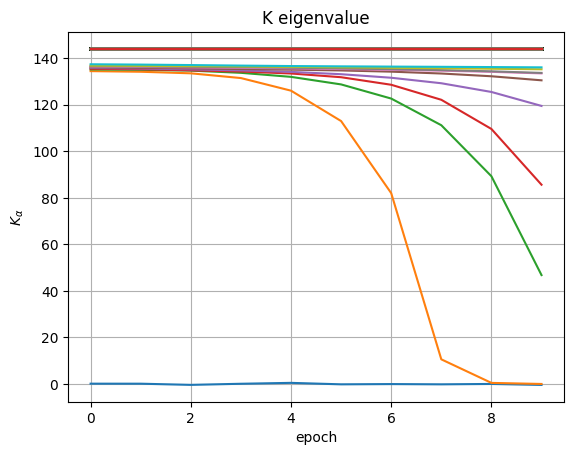

In [14]:
# Kernel SVD values
s_hist = np.zeros((epochs,784))
mu2 = np.diag(np.ones(784))

for i in range(epochs):
    WW_ = history['w'][i].T@history['w'][i]
    K_ = -rbm.sig**2 * WW_ + np.diag(history['m'][i]**2)
    if i ==0:
        K_i = K_.copy()
    s_ = np.sort(np.linalg.eigvals(K_))
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

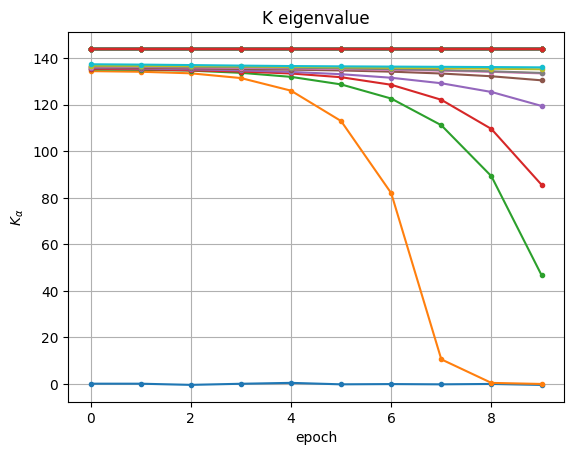

In [15]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


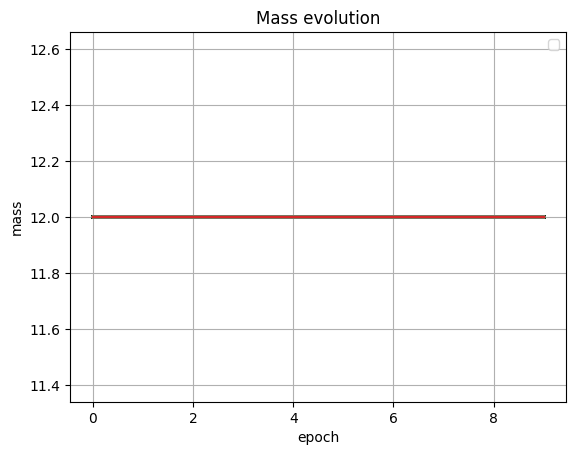

In [16]:
# Mass parameter of the model
plt.plot(np.arange(len(history['m'])),history['m'])
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

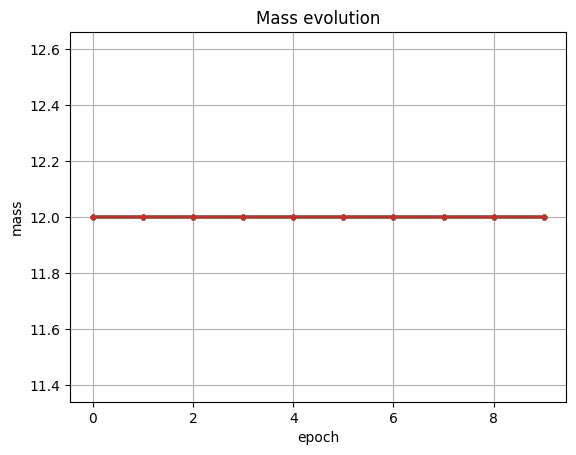

In [17]:
# Last few steps
plt.plot(np.arange(len(history['m']))[-10:],history['m'][-10:], '.-')
# plt.axhline(np.sqrt(m**2 + 2. + 2.), ls='--', color='C3', label='Minimum Cholesky mass limit')
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
# plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

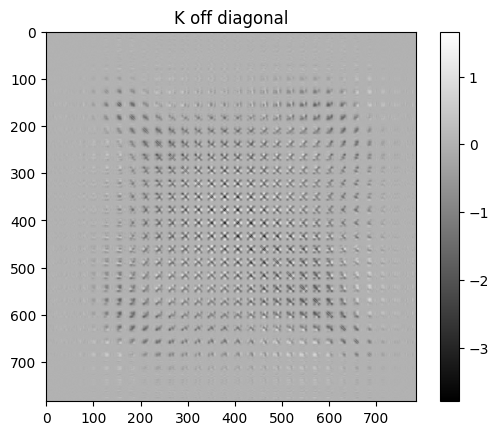

In [18]:
# K_rbm off diagonal part
Kin = (-rbm.sig**2 * (rbm.w.t() @ rbm.w)).data.numpy()
Mss = np.diag((rbm.m**2).data.numpy())
K = Kin + Mss

K_off = K - np.diag(np.diag(K))
plt.imshow(K_off, cmap='gray', vmax=K_off.max(), vmin=K_off.min())
plt.colorbar()
plt.title('K off diagonal')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

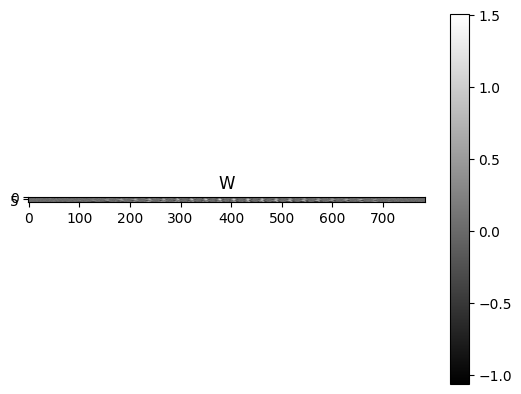

In [19]:
# Coupling matrix as image
w_rbm = rbm.w.data.numpy()
plt.imshow(w_rbm, cmap='gray')
plt.colorbar()
plt.title('W')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

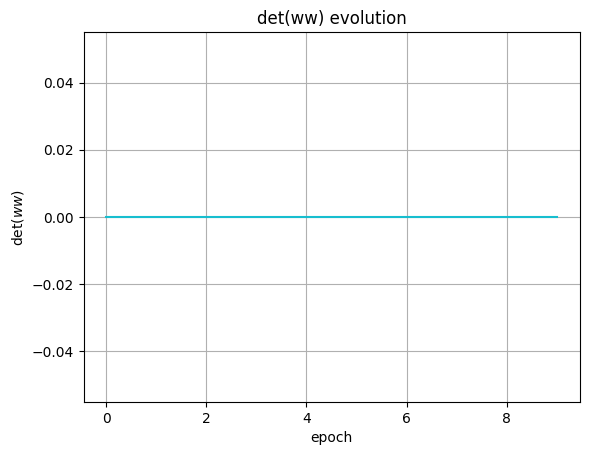

In [20]:
# Evolution of det(ww^T)
det_hist = np.zeros(epochs)
for i in range(epochs):
    det = np.linalg.det(history['w'][i].T @ history['w'][i])
    det_hist[i] = det

plt.plot(np.arange(epochs),det_hist,'C9')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'det($ww$)')
plt.title(r'det(ww) evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

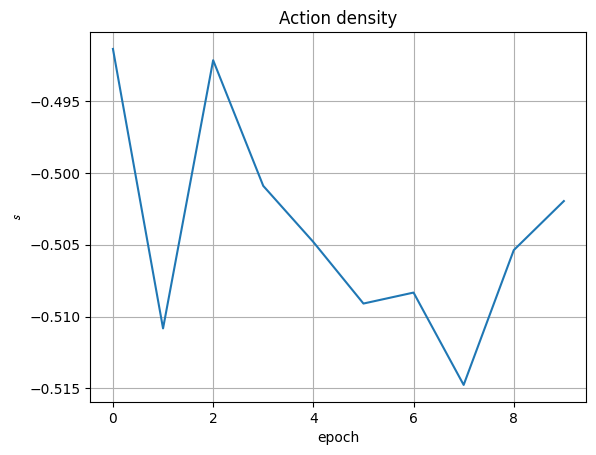

In [21]:
plt.plot(np.arange(len(history['S'])),history['S'])
plt.title('Action density')
plt.xlabel('epoch')
plt.ylabel(r'$\mathcal{s}$')
plt.grid(True)
plt.show()

## Regenerated image

In [22]:
from torchvision.utils import make_grid

In [23]:
def show_img(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)

In [24]:
for data in train_dl:
    1+1

In [25]:
data[0].shape

torch.Size([24, 1, 28, 28])

In [28]:
p_v, v_, _, _, v = rbm.forward(data[0][0:24].reshape(-1,784))

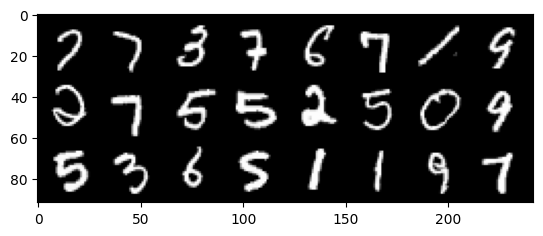

In [29]:
show_img("real",make_grid(v.view(24,1,28,28).data))

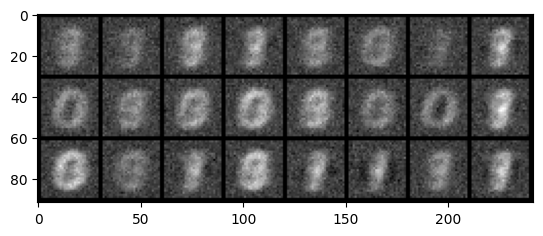

In [30]:
v_scaled = (v_ - v_.min())/(v_ - v_.min()).max()
show_img("real",make_grid(v_scaled.view(24,1,28,28).data))